In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.linalg import expm, fractional_matrix_power

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster

from scipy.stats import zscore

from tqdm.auto import tqdm

import networkx as nx
import igraph as ig

from utils.Multiscale.load_data import load_dict
from utils.Multiscale.multiscale_functions import laplacian_matrix
from netneurotools import plotting, cluster
from netneurotools.metrics import communicability_bin, communicability_wei

import utils.CommonFunctions as cf
import utils.plotter as plotter

from utils.Dynamics import Neuronal

/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
/home/barzon/.local/lib/python3.6/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()


# Data visualization

In [2]:
data = load_dict('data/LAU1000')

In [3]:
data['sc'].shape

(1000, 1000)

In [4]:
data.keys()

dict_keys(['sc', 'fc', 'coords', 'lhannot', 'rhannot', 'noplot', 'order', 'rsn', 'rsn_names', 've', 've_names', 'ci'])

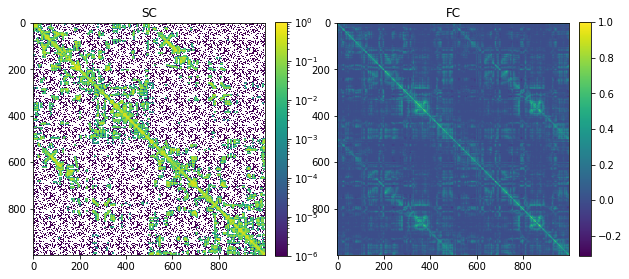

In [5]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(data['sc'], norm=LogNorm(vmin=1e-6, vmax=1))
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('SC')

plt.subplot(1,2,2)
plt.imshow(data['fc'])
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('FC')

plt.show()

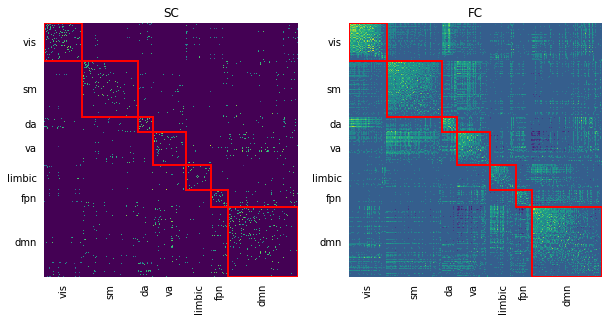

In [6]:
plt.figure(figsize=(10,10))

ax1 = plt.subplot(1,2,1)
plotting.plot_mod_heatmap(data['sc'], data['rsn'], ax=ax1, cbar=False, xlabels=data['rsn_names'], ylabels=data['rsn_names'], edgecolor='red')
plt.title('SC')

ax2 = plt.subplot(1,2,2)
plotting.plot_mod_heatmap(data['fc'], data['rsn'], ax=ax2, cbar=False, xlabels=data['rsn_names'], ylabels=data['rsn_names'], edgecolor='red')
plt.title('FC')

plt.show()

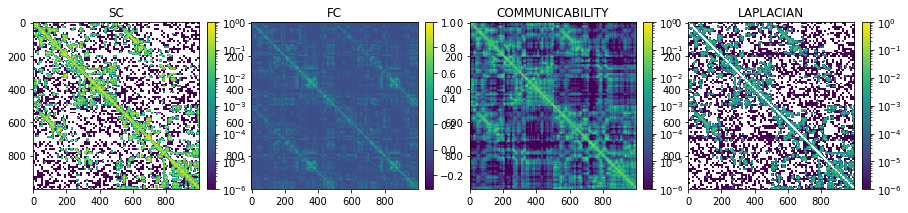

In [7]:
plt.figure(figsize=(15,15))

plt.subplot(1,4,1)
plt.imshow(data['sc'], norm=LogNorm(vmin=1e-6, vmax=1))
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('SC')

plt.subplot(1,4,2)
plt.imshow(data['fc'])
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('FC')

plt.subplot(1,4,3)
plt.imshow(communicability_wei(data['sc']), norm=LogNorm(vmin=1e-6, vmax=1))
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('COMMUNICABILITY')

plt.subplot(1,4,4)
plt.imshow(-laplacian_matrix(data['sc']), norm=LogNorm(vmin=1e-6, vmax=1))
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('LAPLACIAN')

plt.show()

In [ ]:
tt = 3

plt.figure(figsize=(15,15))

ax = plt.subplot(1,4,1)
plotting.plot_mod_heatmap(data['sc'], data['rsn'], ax=ax, cbar=False, xlabels=data['rsn_names'], ylabels=data['rsn_names'], edgecolor='red')
plt.title('SC')

ax = plt.subplot(1,4,2)
plotting.plot_mod_heatmap(data['fc'], data['rsn'], ax=ax, cbar=False, xlabels=data['rsn_names'], ylabels=data['rsn_names'], edgecolor='red')
plt.title('FC')

ax = plt.subplot(1,4,3)
plotting.plot_mod_heatmap(1-mat_dd[tt]/np.max(mat_dd[tt]), data['rsn'], ax=ax, cbar=False, xlabels=data['rsn_names'], ylabels=data['rsn_names'], edgecolor='red')
plt.title('DD-t='+str(ts.flatten()[tt]))

ax = plt.subplot(1,4,4)
plotting.plot_mod_heatmap(np.log10(communicability_wei(data['sc'])), data['rsn'], ax=ax, cbar=False, xlabels=data['rsn_names'], ylabels=data['rsn_names'], edgecolor='red')
plt.title('COMMUNICABILITY')

plt.show()

# Take only one hemisphere

In [6]:
N = data['sc'].shape[0]

sc_left = data['sc'][:N//2,:N//2]
fc_left = data['fc'][:N//2,:N//2]

rsn_left = data['rsn'][:N//2]

In [42]:
def diffusion_distance(mat, t):
    num_nodes = len(mat)
    
    lapl = laplacian_matrix(mat)
    expL = expm(-lapl*t)

    d_ij = np.zeros((num_nodes,num_nodes))
    
    for i in range(0, num_nodes):
        for j in range(i+1, num_nodes):
            d_ij_tmp = expL[i] - expL[j]
            d_ij[i,j] = np.sqrt(d_ij_tmp.dot(d_ij_tmp))
            
    return d_ij + d_ij.T

In [198]:
ts = [[0.001, 0.01, 0.1, 1], [2, 5, 10, 20]]
ts = np.array(ts)

mat_dd = []

for i,t in enumerate(ts.flatten()):
    print('* {}/{} - t={}'.format(i+1,len(ts.flatten()),t))
    tmp = diffusion_distance(sc_left, t=t)
    mat_dd.append(tmp)

* 1/8 - t=0.001
* 2/8 - t=0.01
* 3/8 - t=0.1
* 4/8 - t=1.0
* 5/8 - t=2.0
* 6/8 - t=5.0
* 7/8 - t=10.0
* 8/8 - t=20.0


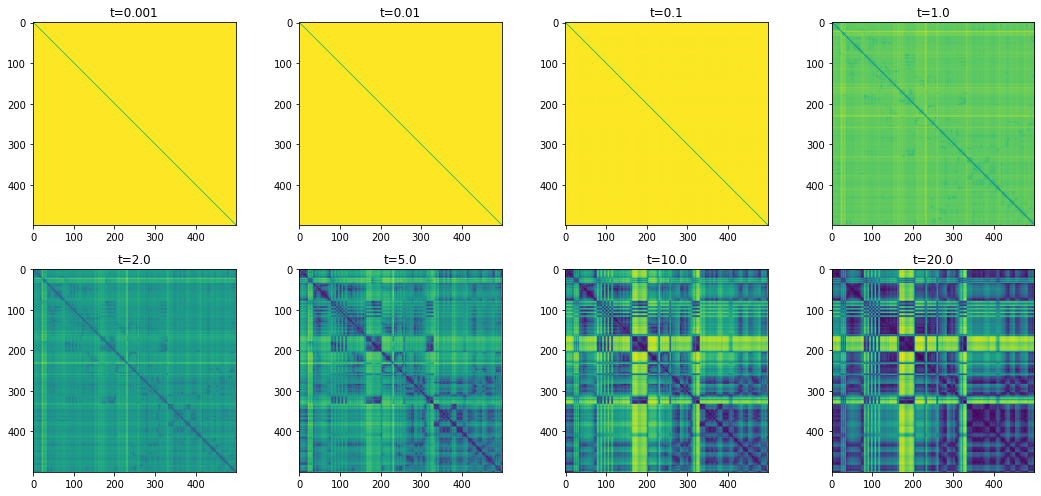

In [199]:
ts = [[0.001, 0.01, 0.1, 1], [2, 5, 10, 20]]
ts = np.array(ts)

plt.figure(figsize=(15,7))

for (x,y), t in np.ndenumerate(ts):
    ax = plt.subplot(ts.shape[0],ts.shape[1],x*ts.shape[1]+y+1)
    plt.imshow(mat_dd[x*ts.shape[1]+y])
    plt.title('t='+str(t))
    
plt.tight_layout()
plt.show()

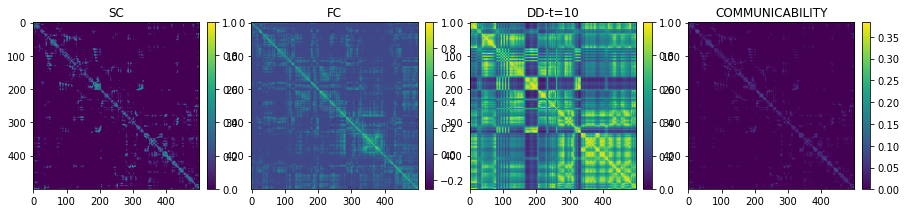

In [53]:
tt = 3

plt.figure(figsize=(15,15))

plt.subplot(1,4,1)
plt.imshow(sc_left)
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('SC')

plt.subplot(1,4,2)
plt.imshow(fc_left)
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('FC')

plt.subplot(1,4,3)
plt.imshow(1-mat_dd[tt]/np.max(mat_dd[tt]))
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('DD-t='+str(ts.flatten()[tt]))

plt.subplot(1,4,4)
plt.imshow(communicability_wei(sc_left))
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('COMMUNICABILITY')

plt.show()

/home/barzon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


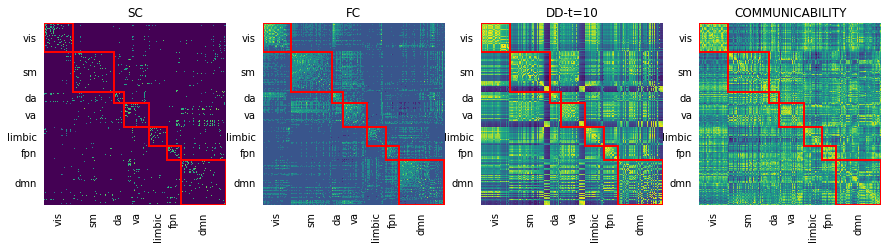

In [54]:
tt = 3

plt.figure(figsize=(15,15))

ax = plt.subplot(1,4,1)
plotting.plot_mod_heatmap(sc_left, rsn_left, ax=ax, cbar=False, xlabels=data['rsn_names'], ylabels=data['rsn_names'], edgecolor='red')
plt.title('SC')

ax = plt.subplot(1,4,2)
plotting.plot_mod_heatmap(fc_left, rsn_left, ax=ax, cbar=False, xlabels=data['rsn_names'], ylabels=data['rsn_names'], edgecolor='red')
plt.title('FC')

ax = plt.subplot(1,4,3)
plotting.plot_mod_heatmap(1-mat_dd[tt]/np.max(mat_dd[tt]), rsn_left, ax=ax, cbar=False, xlabels=data['rsn_names'], ylabels=data['rsn_names'], edgecolor='red')
plt.title('DD-t='+str(ts.flatten()[tt]))

ax = plt.subplot(1,4,4)
plotting.plot_mod_heatmap(np.log10(communicability_wei(sc_left)), rsn_left, ax=ax, cbar=False, xlabels=data['rsn_names'], ylabels=data['rsn_names'], edgecolor='red')
plt.title('COMMUNICABILITY')

plt.show()

# Community detection
see https://igraph.org/python/api/develop/igraph.community.html for clustering methods <br>
see https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics for evaluation metrics

In [10]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score, adjusted_rand_score

def community_detection(mat, method, *args):
    graph = ig.Graph.Weighted_Adjacency(mat.tolist(), mode=ig.ADJ_UNDIRECTED, attr="weight", loops=False)
    
    if method == 'louvain':
        comms = graph.community_multilevel(weights=graph.es['weight'], return_levels=False)
    elif method == 'leiden':
        if len(args)>0:
            resolution_parameter = args[0]
        comms = graph.community_leiden(weights=graph.es['weight'], resolution_parameter=resolution_parameter, n_iterations=-1, objective_function='modularity') #objective_function: Constant Potts Model (CPM) or modularity
    elif method == 'spin_glass':
        comms = graph.community_spinglass(weights=graph.es['weight'], spins=int(1e3))
    elif method == 'infomap':
        comms = graph.community_infomap(edge_weights=graph.es['weight'], trials=10)
    else:
        raise( Exception('Community detection method not defined.\n'))
    
    return comms.membership

def metrics(comms_true, comms_emp, method):
    if method == 'nmi':
        score = normalized_mutual_info_score(comms_true, comms_emp)
    elif method == 'ami':
        score = adjusted_mutual_info_score(comms_true, comms_emp)
    elif method == 'ari':
        score = adjusted_rand_score(comms_true, comms_emp)
    else:
        raise(Exception('Evaluation method not defined.\n'))
    
    return score

## - Louvain

In [44]:
comms = []
mats = [sc_left, communicability_wei(sc_left)]
mat_names = ['SC', 'CC']
method = 'louvain'
scores = ['ami', 'ari']
    
for i, mat in enumerate(mats):
    print('[*] Matrix: '+str(mat_names[i]))
    
    Q = [community_detection(mat, method) for _ in range(100)]
    Q = cluster.find_consensus(np.column_stack(Q))
    print('N cluster: ', len(np.unique(Q)))
    
    comms.append(Q)

[*] Matrix: SC
N cluster:  7
[*] Matrix: CC
N cluster:  7


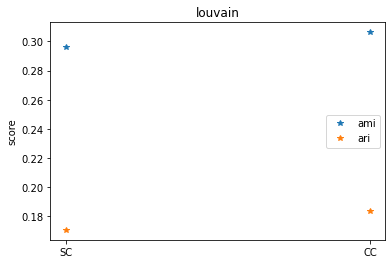

In [45]:
results = [[metrics(rsn_left, comm, score) for comm in comms] for score in scores]

for i, res in enumerate(results):
    plt.plot(mat_names, res, '*', label=scores[i])
    
plt.ylabel('score')
plt.title(method)
plt.legend()
plt.show()

In [212]:
comms = []
mats = [sc_left, communicability_wei(sc_left), -laplacian_matrix(sc_left), fc_left]
mat_names = ['SC', 'CC', 'LP', 'FC']
method = 'louvain'
scores = ['ami', 'ari']
    
for i, mat in enumerate(mats):
    print('[*] Matrix: '+str(mat_names[i]))
    
    mat = zscore(mat)
    mat -= mat.min()
        
    Q = [community_detection(mat, method) for _ in range(1000)]
    Q = cluster.find_consensus(np.column_stack(Q))
    print('N cluster: ', len(np.unique(Q)))
    
    comms.append(Q)

[*] Matrix: SC
N cluster:  8
[*] Matrix: CC
N cluster:  7
[*] Matrix: LP
N cluster:  4
[*] Matrix: FC
N cluster:  4


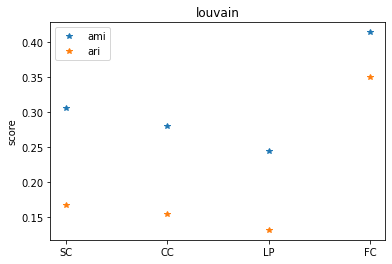

In [213]:
results = [[metrics(rsn_left, comm, score) for comm in comms] for score in scores]

for i, res in enumerate(results):
    plt.plot(mat_names, res, '*', label=scores[i])
    
plt.ylabel('score')
plt.title(method)
plt.legend()
plt.show()

## -Diffusion distance

In [ ]:
avg_dd = average_diffusion_distance(sc_left)

  0%|          | 0/500 [00:00<?, ?it/s]

COMMUNITY DETECTION - DIFFUSION DISTANCE
** Diffusion distance already computed
- Compute hierarchical clustering with method complete...
- Loop over induced graphs...


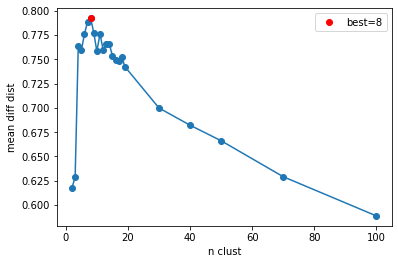

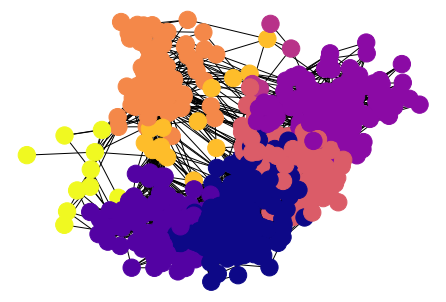

COMMUNITY DETECTION - DIFFUSION DISTANCE
** Diffusion distance already computed
- Compute hierarchical clustering with method complete...
- Loop over induced graphs...


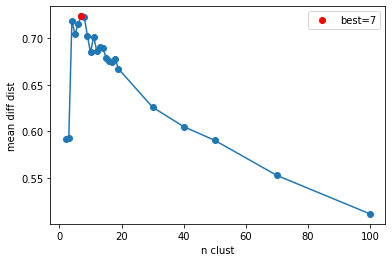

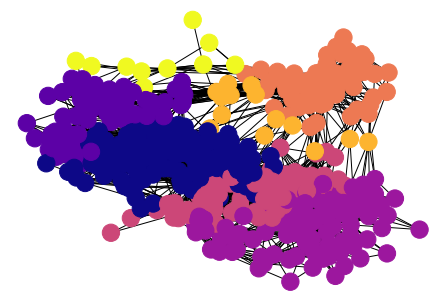

COMMUNITY DETECTION - DIFFUSION DISTANCE
** Diffusion distance already computed
- Compute hierarchical clustering with method complete...
- Loop over induced graphs...


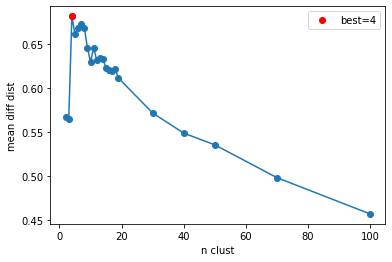

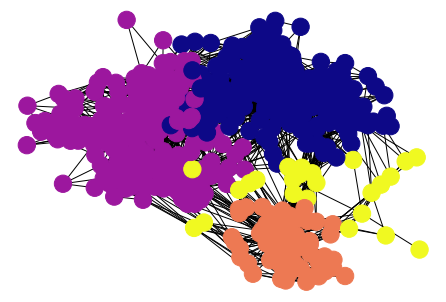

COMMUNITY DETECTION - DIFFUSION DISTANCE
** Diffusion distance already computed
- Compute hierarchical clustering with method complete...
- Loop over induced graphs...


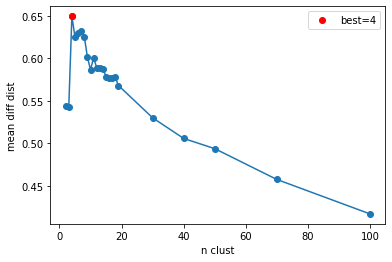

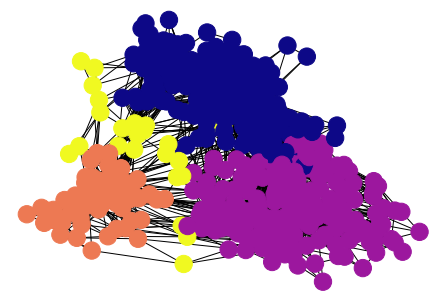

In [14]:
res = []
ts = [2, 3, 4, 5]

for tmax in ts:
    tmp = clustering_diffusion_distance(sc_left, precomputed=avg_dd, method='complete', tmax=tmax)
    res.append(tmp)

In [16]:
for tmp in res:
    print(metrics(rsn_left, tmp[-1], 'nmi'))

0.2583832882269552
0.25118349099482823
0.2259444539353549
0.2259444539353549


In [51]:
n_states = np.arange(2,50)

res = []

Z = linkage(squareform(avg_dd), method='complete')

for n_stat in n_states:
    comms_emp = fcluster(Z, t=n_stat, criterion='maxclust') -1
    score = adjusted_mutual_info_score(rsn_left, comms_emp)
    res.append(score)

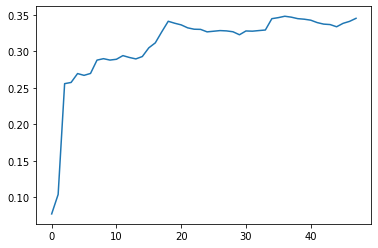

In [52]:
plt.plot(res)
plt.show()

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method complete...
- Loop over induced graphs - max clust = 20...


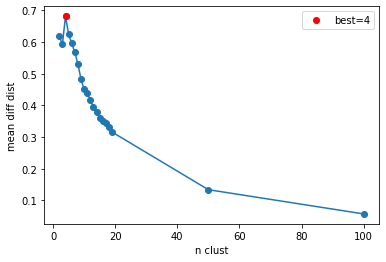

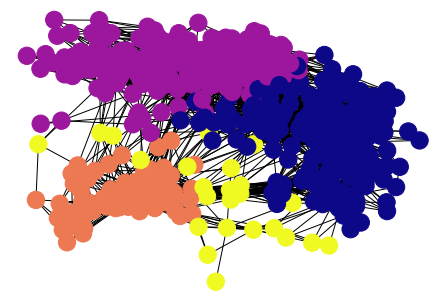

In [52]:
res = clustering_diffusion_distance(sc_left, precomputed=avg_dd, method='complete')

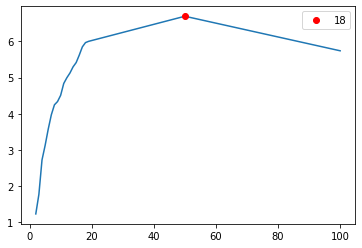

In [53]:
plt.plot(res[0], res[1]*res[0])
plt.plot(res[0][np.argmax(res[1]*res[0])], (res[1]*res[0])[np.argmax(res[1]*res[0])], 'o', c='r', label=np.argmax(res[1]*res[0]))
plt.legend()
plt.show()

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method single...
- Loop over induced graphs - max clust = 20...


/home/barzon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


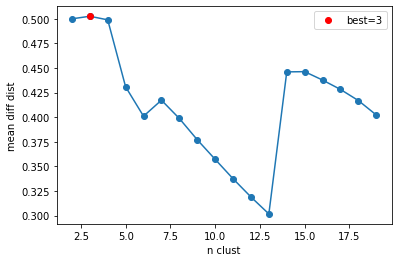

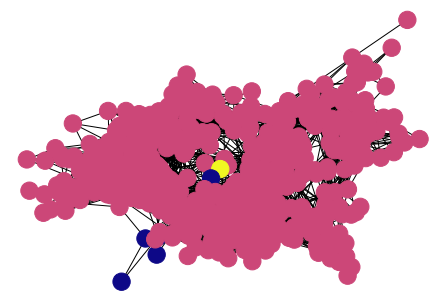

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method complete...
- Loop over induced graphs - max clust = 20...


/home/barzon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


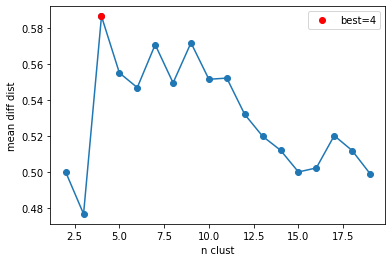

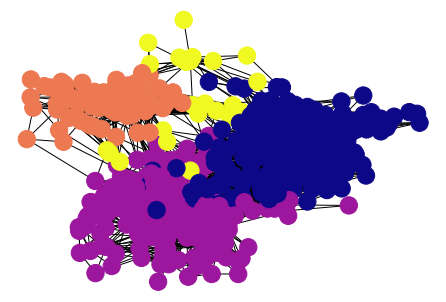

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method average...
- Loop over induced graphs - max clust = 20...


/home/barzon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


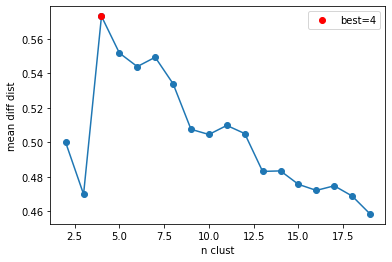

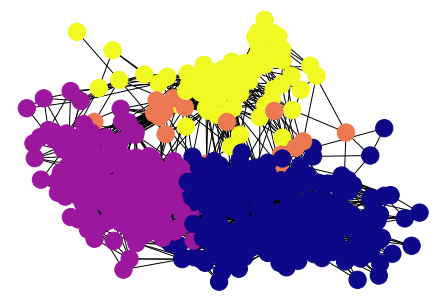

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method weighted...
- Loop over induced graphs - max clust = 20...


/home/barzon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


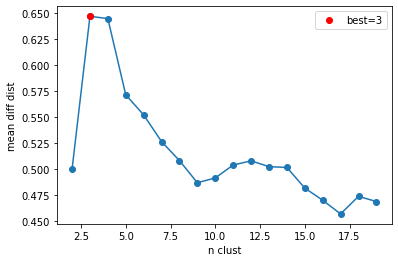

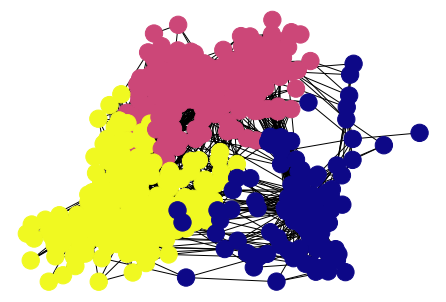

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method ward...
- Loop over induced graphs - max clust = 20...


/home/barzon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


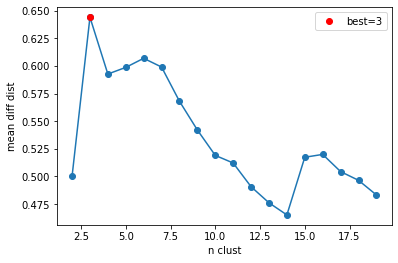

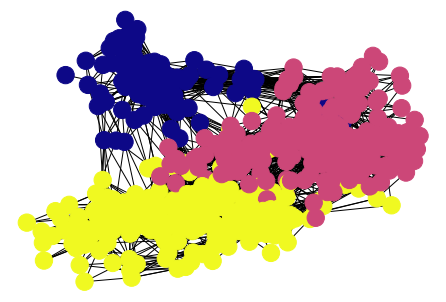

In [45]:
res = []

methods_clust = ['single', 'complete', 'average', 'weighted', 'ward']

for method in methods:
    tmp = clustering_diffusion_distance(sc_left, precomputed=avg_dd, clust_max=20, show=True, method=method)
    res.append(tmp)

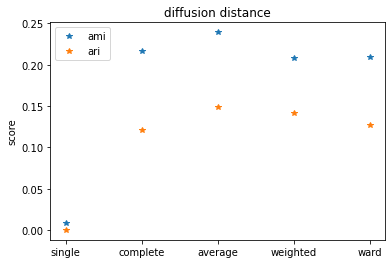

In [31]:
scores = ['ami', 'ari']

results = [[metrics(rsn_left, tmp[-1], score) for tmp in res] for score in scores]

for i, res in enumerate(results):
    plt.plot(methods_clust, res, '*', label=scores[i])
    
plt.ylabel('score')

plt.title('diffusion distance')
plt.legend()
plt.show()

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method weighted...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.12


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.14


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.12


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.11


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.09


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.07


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.05


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


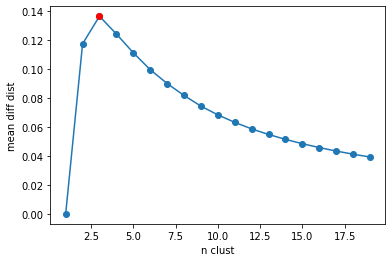

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method weighted...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.18


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.15


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.13


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.11


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.09


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.07


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.05


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


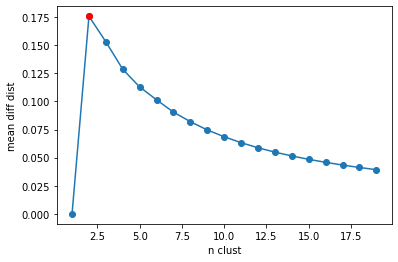

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method weighted...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.16


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.16


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.14


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.12


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.11


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.09


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.08


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.06


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


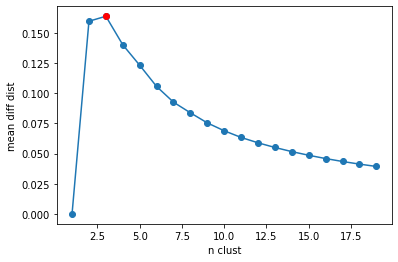

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method weighted...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.17


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.17


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.15


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.13


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.11


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.1


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.09


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.08


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.07


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.06


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


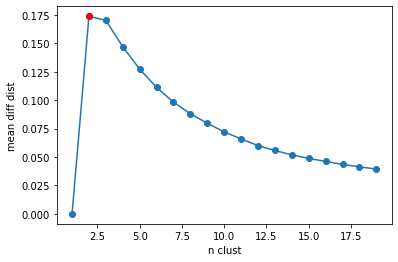

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method weighted...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.17


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.17


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.15


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.13


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.11


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.1


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.08


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.06


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


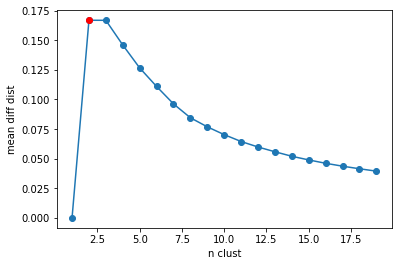

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method weighted...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.16


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.13


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.13


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.11


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.09


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.07


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.05


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


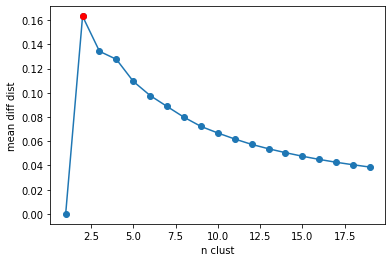

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method weighted...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.11


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.11


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.11


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.1


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.09


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.09


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.07


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.05


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.04


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


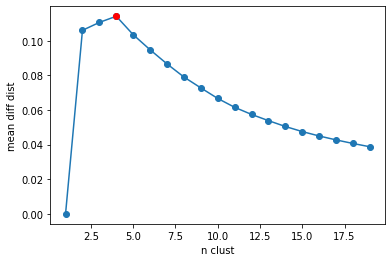

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method weighted...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.09


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.1


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.11


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.1


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.09


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.09


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.07


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.05


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


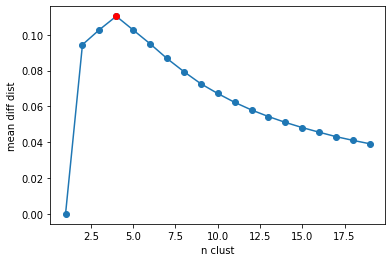

In [206]:
res_dd = []

for mat in mat_dd:
    tmp = clustering_diffusion_distance(mat, precomputed=True, clust_max=20, show=True, method='weighted')
    res_dd.append(tmp)

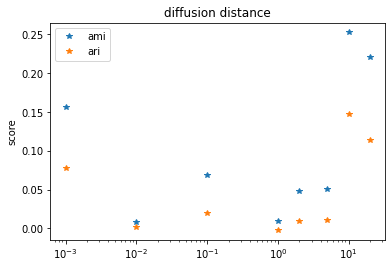

In [207]:
results = [[metrics(rsn_left, tmp[-1], score) for tmp in res_dd] for score in scores]

for i, res in enumerate(results):
    plt.plot(ts.flatten(), res, '*', label=scores[i])
    
plt.ylabel('score')
plt.xscale('log')

plt.title('diffusion distance')
plt.legend()
plt.show()

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method complete...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.18


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.17


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.15


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.13


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.11


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.1


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.09


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.08


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.07


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.06


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


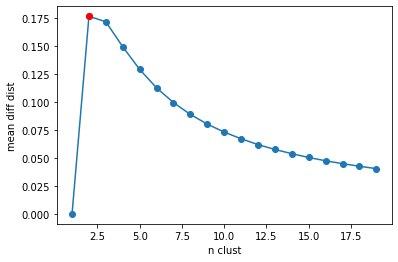

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method complete...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.18


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.17


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.15


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.13


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.11


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.1


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.09


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.08


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.07


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.06


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


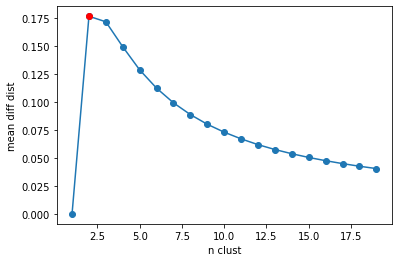

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method complete...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.18


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.17


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.15


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.13


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.11


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.1


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.09


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.08


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.07


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.06


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


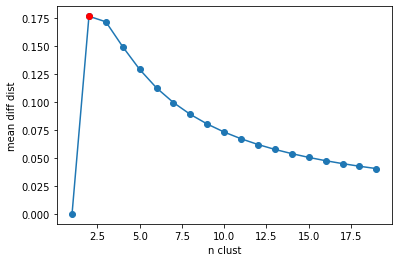

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method complete...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.18


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.17


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.15


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.13


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.11


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.1


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.09


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.08


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.07


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.06


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


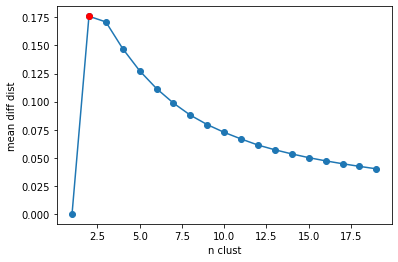

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method complete...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.17


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.17


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.15


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.13


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.11


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.1


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.09


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.08


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.07


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.06


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


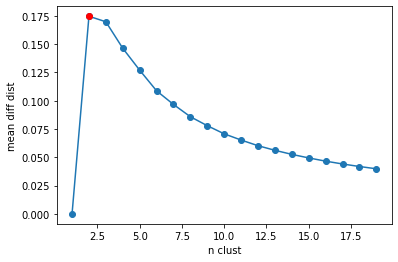

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method complete...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.16


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.16


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.13


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.11


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.09


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.07


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.05


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.04


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


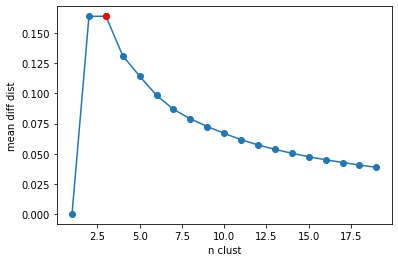

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method complete...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.11


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.11


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.11


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.1


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.09


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.09


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.07


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.05


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.04


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


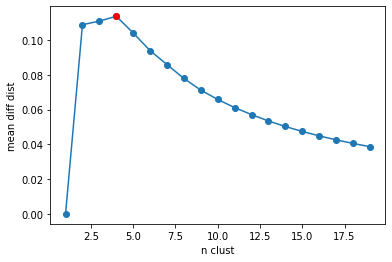

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method complete...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.09


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.1


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.11


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.1


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.09


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.09


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.07


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.05


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


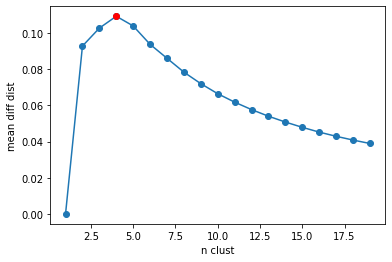

In [214]:
res_dd = []

for mat in mat_dd:
    tmp = clustering_diffusion_distance(mat, precomputed=True, clust_max=20, show=True, method='complete')
    res_dd.append(tmp)

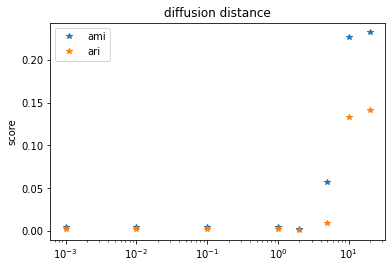

In [215]:
results = [[metrics(rsn_left, tmp[-1], score) for tmp in res_dd] for score in scores]

for i, res in enumerate(results):
    plt.plot(ts.flatten(), res, '*', label=scores[i])
    
plt.ylabel('score')
plt.xscale('log')

plt.title('diffusion distance')
plt.legend()
plt.show()

### * Using normalized laplacian instead of random walk

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method single...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.17


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.17


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.15


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.13


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.11


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.1


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.09


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.08


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.07


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.06


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


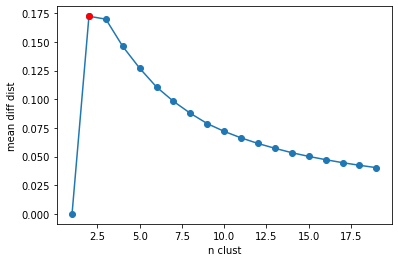

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method complete...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.09


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.11


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.11


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.11


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.09


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.07


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.05


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


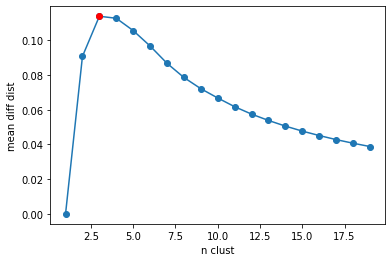

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method average...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.12


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.12


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.12


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.1


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.09


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.07


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.05


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


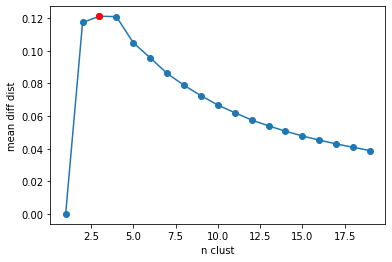

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method weighted...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.1


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.12


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.12


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.11


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.09


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.07


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.05


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


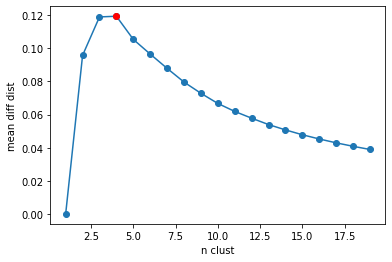

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method ward...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.09


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.11


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.11


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.1


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.09


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.09


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.07


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.05


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


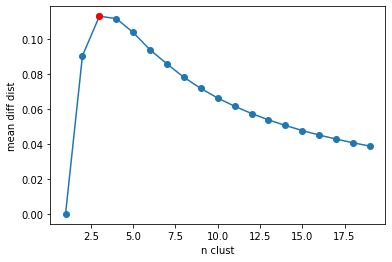

In [191]:
clust_dd = []

for method in methods_clust:
    tmp = clustering_diffusion_distance(avg_dd_2, precomputed=True, clust_max=20, show=True, method=method)
    clust_dd.append(tmp)

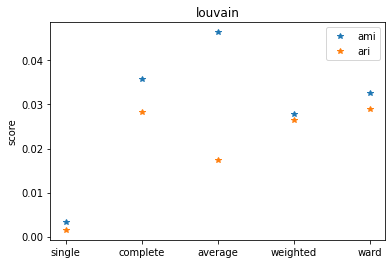

In [194]:
results = [[metrics(rsn_left, tmp[-1], score) for tmp in clust_dd] for score in scores]

for i, res in enumerate(results):
    plt.plot(methods_clust, res, '*', label=scores[i])
    
plt.ylabel('score')

plt.title(method)
plt.legend()
plt.show()